# SIR Model for COVID-19 prediction

First, import.

In [1]:
import numpy as np
import pandas as pd
import math
import datetime
from scipy.integrate import odeint
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [3]:
#read data 
data=pd.read_csv("time-series-19-covid-combined.csv")
data.head()

,Date,Country/Region,Province/State,Lat,Long,Confirmed,Recovered,Deaths
0,2020-01-22,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0
1,2020-01-23,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0
2,2020-01-24,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0
3,2020-01-25,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0
4,2020-01-26,Afghanistan,NaN,33.0,65.0,0.0,0.0,0.0


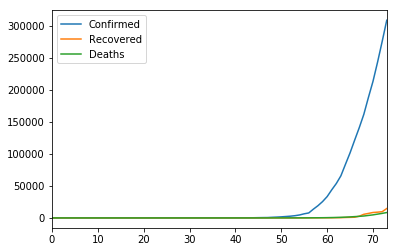

In [7]:
#Preprocessing our data
#At frist, extract US data for our project 
US_data=data.loc[data.loc[:,'Country/Region']=='US']
#reset the index 
US_data.index=[i for i in range (US_data.shape[0])]
#visualize the data
US_data.loc[:,['Confirmed', 'Recovered','Deaths']].plot()

In [10]:
#set the time of first case in USA as 'start'
start = datetime.datetime.strptime('2020-01-22', "%Y-%m-%d")
#set the end time we want to use to estimate beta as 'end'. We want to use '2020-04-04' as end time to estimate the beta. 
end=datetime.datetime.strptime('2020-04-04', "%Y-%m-%d")
#create the index of time between '2020-01-22' and '2020-04-04'
timerange=np.array([i for i in range((start - start).days,(end - start).days+1)])
timerange

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73])

We are known that beta can be decomposed into nContact * infection_Probability, nContact means that an infected person can contact the number of people each day. In our project, nContact we pretend to know, and it equals to 5 between '2020-01-22' and '2020-04-04'. But infection_Probability is unknown. We should use method to estimate. The following codes are used to estimate Infection_Probability. 

In [12]:
class InfectProb:
    def __init__(self, timerange, nContact, gamma):
        self.timerange = timerange
        self.nContact, self.gamma = nContact, gamma
        self.data=US_data
    def object_function(self,infectionProb):
        vector=np.array(np.exp((infectionProb*self.nContact-self.gamma)*self.timerange)-self.data.loc[self.timerange,'Confirmed'])
        return ((vector**2).sum())

Infection_Prob_function=InfectProb(timerange, 5 ,1/14)
InfectionProb_estimated=minimize(Infection_Prob_function.object_function, 0.04, method='nelder-mead', options={'xtol': 1e-8, 'disp': True}).x


Optimization terminated successfully.
         Current function value: 3934932090.702734
         Iterations: 29
         Function evaluations: 58


The define our SIR model.

In [14]:
class SIRModel:
    def __init__(self, N, beta, gamma):
        self.beta= beta
        self.gamma=gamma
        self.N=N
        self.t=np.linspace(0,360,361)
    def odemodel(self, population,t):
        diff=np.zeros(3)
        s,i,r=population
        diff[0] = - self.beta * s * i / self.N
        diff[1] = self.beta * s * i / self.N - self.gamma * i
        diff[2] = self.gamma * i
        return diff


In [17]:
# set our initial values for beta, gamma, N(we pretend to say the initial S squals to N(the popluation of USA))
nContact_train=4.5
beta = nContact_train*InfectionProb_estimated[0]
gamma=1/14
N=327.2*100*10000 # the population of USA
our_SIR=SIRModel(N,beta,gamma)
predict=odeint(our_SIR.odemodel,[N-1,1,0],np.linspace(0,360,361)) # predict 1 year situation.
cumulate_predict_confirm=[predict[0:i,1].sum() for i in range(predict.shape[0]+1)] # compute the culmulative confirmed cases

Visualize

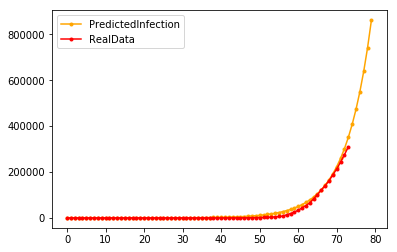

In [18]:
#predict confirmed cases for 80 days from '2020-01-22'
plt.plot(cumulate_predict_confirm[0:80],color = 'orange',label = 'PredictedInfection',marker = '.')
plt.plot(US_data.Confirmed,color = 'red',label = 'RealData',marker = '.')
plt.legend()

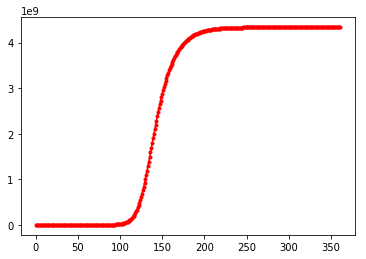

In [19]:
#predict confirmed cases for 1 year from '2020-01-22'
plt.plot(cumulate_predict_confirm,color = 'red',label = 'realdata',marker = '.')

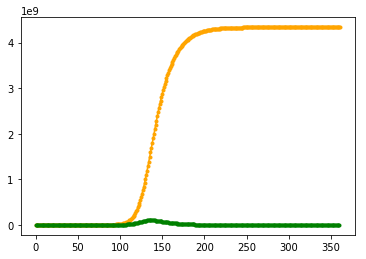

In [21]:
#predict confirmed cases and recovered cases for 1 year from '2020-01-22' without any control.
plt.plot(cumulate_predict_confirm,color = 'orange',label = 'PredictedInfection',marker = '.')
plt.plot(predict[:,1],color = 'green',label = 'RealData',marker = '.')

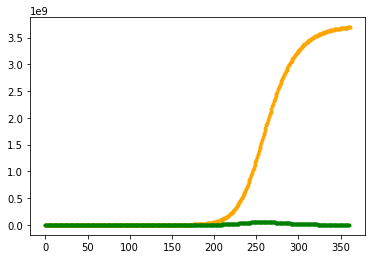

In [23]:
#If US take actions, but not serious actions. We set ncontact to 3. And see what the curve will be. 
nContact_train=3
beta = nContact_train*InfectionProb_estimated[0]
gamma=1/14
N=327.2*100*10000 # the population of USA
our_SIR=SIRModel(N,beta,gamma)
predict=odeint(our_SIR.odemodel,[N-1,1,0],np.linspace(0,360,361)) # predict 1 year situation.
cumulate_predict_confirm=[predict[0:i,1].sum() for i in range(predict.shape[0]+1)] # compute the culmulative confirmed cases
plt.plot(cumulate_predict_confirm,color = 'orange',label = 'PredictedInfection',marker = '.')
plt.plot(predict[:,1],color = 'green',label = 'RealData',marker = '.')

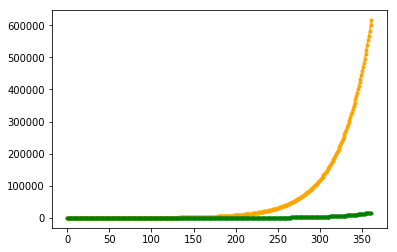

In [24]:
#If US take serious actions, like Wuhan, China. We set ncontact to 2. And see what the curve will be. 
nContact_train=2
beta = nContact_train*InfectionProb_estimated[0]
gamma=1/14
N=327.2*100*10000 # the population of USA
our_SIR=SIRModel(N,beta,gamma)
predict=odeint(our_SIR.odemodel,[N-1,1,0],np.linspace(0,360,361)) # predict 1 year situation.
cumulate_predict_confirm=[predict[0:i,1].sum() for i in range(predict.shape[0]+1)] # compute the culmulative confirmed cases
plt.plot(cumulate_predict_confirm,color = 'orange',label = 'PredictedInfection',marker = '.')
plt.plot(predict[:,1],color = 'green',label = 'RealData',marker = '.')